## Import of required libraries

In [1]:
!pip install ultralytics
!pip install pytesseract
!pip install timm
!pip install -q transformers==4.47.1
!pip install transformers[torch]
!pip install globox
!pip install pycocotools
!pip install -q torchmetrics
!apt-get install tesseract-ocr -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 100 not upgraded.


In [2]:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pytesseract
import os
import shutil
import pandas as pd
import numpy as np

from PIL import Image
from pytesseract import Output
from ultralytics import SAM
from ultralytics import YOLO

from pathlib import Path
from torchvision.datasets import CocoDetection
from globox import AnnotationSet, Annotation, BoundingBox
import matplotlib.patches as patches

import torch
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
import timm
from transformers import DetrForObjectDetection, DetrFeatureExtractor, DetrConfig, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import precision_score, recall_score, average_precision_score
from functools import partial
from dataclasses import dataclass
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from transformers.image_transforms import center_to_corners_format


os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_DISABLED"] = "true"


## Library

In [4]:
class YoloDetector:
    def __init__(self, size = 'm', path = None):
        if path is not None:
          self.model = YOLO(path)
        else:
          self.model = YOLO(f'yolov8{size}.pt')

    def train(self, yaml_file, epochs=100):
        results = self.model.train(data=yaml_file, epochs=epochs, patience=3)
        metrics = self.model.val()
        return results, metrics

    def predict(self, img, visualize = True):
        r = self.model(img)
        if visualize:
          plt.figure(figsize=(8, 10))
          plt.imshow(r[0].plot())
          plt.show()
        return r

    def save(self, path):
        self.model.save(path)

In [5]:
# Define the function to calculate the Intersection over Union (IoU) of two boxes
def bb_intersection_over_union(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Compute the intersection over union by taking the intersection area and dividing it by the sum of prediction + ground-truth areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # Return the intersection over union value
    return iou

# Define the function to eliminate boxes that overlap with boxes in another array
def eliminate_overlapping_boxes(sbboxes, scores, ybboxes, iou_threshold=0.5):
    # List to keep track of boxes to keep
    filtered_boxes = []
    filtered_scores = []

    # Iterate over each box in sbboxes
    for i, sbbox in enumerate(sbboxes):
        keep_box = True
        # Check for overlap with each box in ybboxes
        for ybbox in ybboxes:
            if bb_intersection_over_union(sbbox, ybbox) > iou_threshold:
                keep_box = False
                break
        # If box does not overlap, add it to the list of boxes to keep
        if keep_box:
            filtered_boxes.append(sbbox)
            filtered_scores.append(scores[i])

    return np.array(filtered_boxes), np.array(filtered_scores)

def plot_boxes(img, bboxes, classes, scores, color = (255, 255, 255)):
    for bbox, cls, score in zip(bboxes, classes, scores):
        # Draw a rectangle around the box
        (x1, y1, x2, y2) = map(int, bbox)
        # print(bbox[0])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), 2)


        # Set the background color and text size
        background_color = (255, 0, 0)
        text = f'{cls} {score:.2f}'
        font_scale = 0.6
        font_thickness = 1

        # Get the width and height of the text box
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)

        # Draw the filled rectangle (background of the text)
        cv2.rectangle(img, (x1, y1 - text_height), (x1 + text_width, y1), background_color, -1)

        # cv2.putText(img, f'{cls} {score:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, .5, (0, 0, 0), 1, cv2.LINE_AA, bgColour=(255, 0, 0))
        cv2.putText(img, text, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, font_thickness, cv2.LINE_AA)

    return img

def plot_img(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()


def run_yolo_inference(paths, custom_image_dir, yl):
    img_path = [os.path.join(custom_image_dir, _) for _ in paths];
    img_test = [cv2.imread(_) for _ in img_path]
    img_test = [cv2.cvtColor(_, cv2.COLOR_BGR2RGB) for _ in img_test]
    yresults = yl.predict([i.copy() for i in img_test], visualize=False)


    for i, y, p, id in zip(img_test, yresults, paths, range(len(paths))):
      s = sam_model(i.copy())[0]

      ybboxes = np.array(y.boxes.xyxy.cpu())
      yscores = np.array(y.boxes.conf.cpu())

      ycls = np.array(y.boxes.cls.cpu())
      ycls = [targets[int(_)] for _ in ycls]

      s_bboxes, s_scores = eliminate_overlapping_boxes(np.array(s.boxes.xyxy.cpu()), np.array(s.boxes.conf.cpu()), ybboxes, 0.1)

      print(f"/_____________________________/")
      print(f"Fichier {id}: {p}")
      print("\n")
      print(f"Affichage de la detection des classes par YOLO")
      print("\n")
      ploted_img = plot_boxes(i.copy(), ybboxes, ycls, yscores)
      plot_img(ploted_img)

      print("\n")
      print("\n")
      print(f"Affichage de la detection de forme par SAM")
      print("\n")
      ploted_img = plot_boxes(ploted_img, s_bboxes, [''] * len(s_bboxes), s_scores)
      plot_img(ploted_img)

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    # pixel_mask = [item[1] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    # print(labels)
    return {"pixel_values": encoding["pixel_values"], "pixel_mask": encoding["pixel_mask"], "labels": labels}

In [6]:
# 4. Create a custom dataset class
class CustomCocoDataset(Dataset):
    def __init__(self, annotations_file, img_dir, feature_extractor, transforms=None):
        self.coco = COCO(annotations_file)
        self.img_dir = img_dir
        self.feature_extractor = feature_extractor
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']
        img_path = os.path.join(self.img_dir, path)
        img = Image.open(img_path).convert("RGB")

        if self.transforms:
            img = self.transforms(img)

        # print('anns', anns)
        anns = {"image_id":img_id,  "annotations": anns}
        encoding = self.feature_extractor(images=img, annotations=anns, return_tensors="pt")

        pixel_values = encoding["pixel_values"].squeeze()
        # print(encoding["labels"])
        target = encoding["labels"][0]
        # target = encoding["labels"]

        # full_encoding = self.feature_extractor.pad(pixel_values, return_tensors="pt")

        # print('anns', anns, target)
        return pixel_values, target

# Function for quick inference
def run_detr_inference(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    # Run inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process the outputs
    target_sizes = torch.tensor([image.size[::-1]])
    results = feature_extractor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

    # Plot the image and draw bounding boxes
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        if score > 0.5:  # Threshold for displaying bounding boxes
            box = box.cpu().numpy()
            x, y, w, h = box
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x, y, f"{id2label[label.item()]}: {score:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

In [7]:
@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


@torch.no_grad()
def compute_metrics(evaluation_results, image_processor, threshold=0.0, id2label=None):
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids
    # print(targets)

    # For metric computation we need to provide:
    #  - targets in a form of list of dictionaries with keys "boxes", "labels"
    #  - predictions in a form of list of dictionaries with keys "boxes", "scores", "labels"

    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    # Collect targets in the required format for metric computation
    for batch in targets:
        # collect image sizes, we will need them for predictions post processing
        # print('batch', batch)
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch]))
        image_sizes.append(batch_image_sizes)
        # collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max)
        for image_target in batch:
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_yolo_to_pascal(boxes, image_target["orig_size"])
            labels = torch.tensor(image_target["class_labels"])
            post_processed_targets.append({"boxes": boxes, "labels": labels})

    # Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format, then image_processor convert them to Pascal VOC format
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
        post_processed_output = image_processor.post_process_object_detection(
            output, threshold=threshold, target_sizes=target_sizes
        )
        post_processed_predictions.extend(post_processed_output)

    # Compute metrics
    metric = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
    metric.update(post_processed_predictions, post_processed_targets)
    metrics = metric.compute()

    # Replace list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")
    mar_100_per_class = metrics.pop("mar_100_per_class")
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map
        metrics[f"mar_100_{class_name}"] = class_mar

    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

    return metrics


def convert_bbox_yolo_to_pascal(boxes, image_size):
    """
    Convert bounding boxes from YOLO format (x_center, y_center, width, height) in range [0, 1]
    to Pascal VOC format (x_min, y_min, x_max, y_max) in absolute coordinates.

    Args:
        boxes (torch.Tensor): Bounding boxes in YOLO format
        image_size (Tuple[int, int]): Image size in format (height, width)

    Returns:
        torch.Tensor: Bounding boxes in Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    # convert center to corners format
    boxes = center_to_corners_format(boxes)

    # convert to absolute coordinates
    height, width = image_size
    boxes = boxes * torch.tensor([[width, height, width, height]])

    return boxes

In [8]:
yaml_file = 'conf.yaml'
targets = ['Barcode', 'Logo', 'Qrcode', 'Texte']
label_names = targets
id2label = {k: v for k, v in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
num_classes = len(label_names)

## Training

In [8]:
# Load a SAM model
sam_model = SAM('sam_b.pt')

# Initiation du modele YOLOv8
yl = YoloDetector()

In [9]:
# Entrainement du modele Yolo
epochs = 15
results, metrics = yl.train(yaml_file, epochs=epochs)

Ultralytics 8.3.57 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=conf.yaml, epochs=15, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

100%|██████████| 755k/755k [00:00<00:00, 138MB/s]

Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

 21                  -1  2   4207104  ultralytics.nn.modules.block.C2f             [960, 576, 2]                 
 22        [15, 18, 21]  1   3778012  ultralytics.nn.modules.head.Detect           [4, [192, 384, 576]]          
Model summary: 295 layers, 25,858,636 parameters, 25,858,620 gradients, 79.1 GFLOPs

Transferred 469/475 items from pretrained weights
TensorBoard: Start with 'tensorboard --logdir runs/detect/train', view at http://localhost:6006/
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /notebooks/products_packaging/train/labels.cache... 191 images, 0 backgrounds, 0 corrupt: 100%|██████████| 191/191 [00:00<?, ?it/s]
val: Scanning /notebooks/products_packaging/val/labels.cache... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15      6.71G      1.932       3.51      1.677        206        640: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         77        491      0.518      0.275      0.221       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15      6.76G       1.37      1.766      1.268        186        640: 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]

                   all         77        491      0.381      0.569      0.409      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15      6.79G      1.306      1.509      1.255        129        640: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.65it/s]

                   all         77        491      0.491      0.374      0.417      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      6.78G      1.334      1.426      1.265        179        640: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]

                   all         77        491      0.487      0.321      0.336      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15      6.78G      1.314      1.449       1.26        145        640: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.90it/s]

                   all         77        491      0.365      0.332       0.25      0.146


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      6.69G      1.328      1.547      1.279         88        640: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all         77        491      0.205       0.44      0.169     0.0825
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 3, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



6 epochs completed in 0.011 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:06<00:00,  2.14s/it]


                   all         77        491      0.491      0.374      0.417      0.272
               Barcode         16         17      0.893      0.495       0.58      0.355
                  Logo         69         90      0.699     0.0889      0.207      0.103
                Qrcode          5          5      0.334        0.8      0.797      0.589
                 Texte         74        379     0.0362       0.11     0.0843     0.0414
Speed: 0.1ms preprocess, 4.3ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.57 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A4000, 16109MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /notebooks/products_packaging/val/labels.cache... 77 images, 0 backgrounds, 0 corrupt: 100%|██████████| 77/77 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]


                   all         77        491      0.552      0.402       0.43      0.283
               Barcode         16         17      0.898      0.519      0.581      0.344
                  Logo         69         90      0.727      0.119      0.223      0.109
                Qrcode          5          5      0.498        0.8      0.799       0.62
                 Texte         74        379      0.086      0.172      0.118     0.0576
Speed: 0.1ms preprocess, 60.3ms inference, 0.0ms loss, 62.9ms postprocess per image
Results saved to runs/detect/train6


In [ ]:
# shutil.make_archive('./model_result', 'zip', '/content/runs/detect')

### Performances on fine-tunning

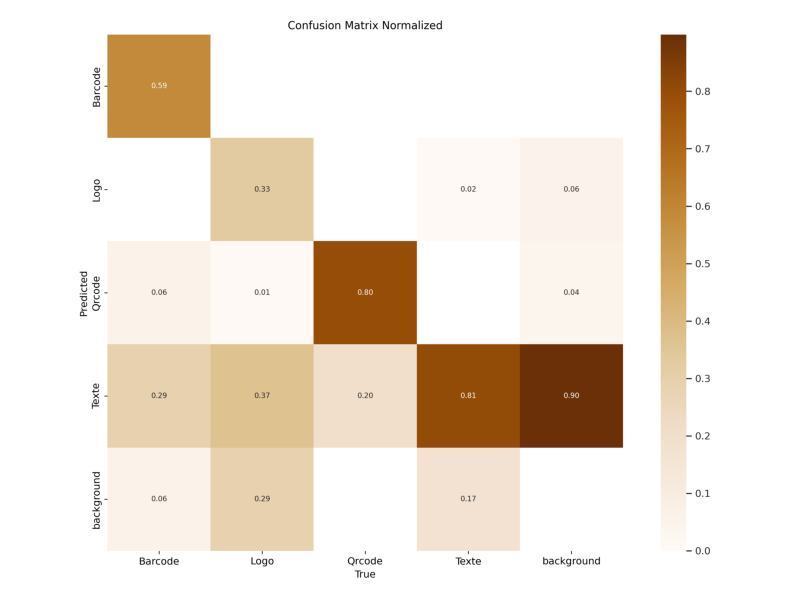

In [10]:
plot_img(cv2.imread("runs/detect/train6/confusion_matrix_normalized.png"))

## Inference with yolo

In [11]:
# Define the directory where the custom images are stored
custom_image_dir = 'products_packaging/test/images'

# Get the list of image files in the directory
# image_files = os.listdir(custom_image_dir)
image_files = ["feb96e84-5.PNG", "fde28d0e-Chickapea.PNG"]


0: 640x640 2 Logos, 13 Textes, 25.1ms
1: 640x640 1 Logo, 4 Textes, 25.1ms
Speed: 12.8ms preprocess, 25.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 1 66, 17681.0ms
Speed: 7.0ms preprocess, 17681.0ms inference, 10.5ms postprocess per image at shape (1, 3, 1024, 1024)
/_____________________________/
Fichier 0: feb96e84-5.PNG


Affichage de la detection des classes par YOLO




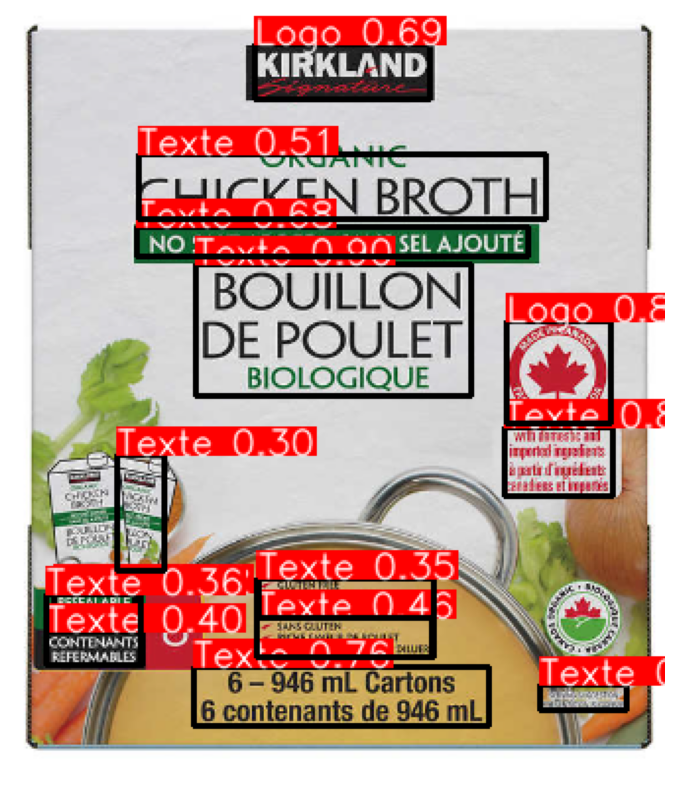





Affichage de la detection de forme par SAM




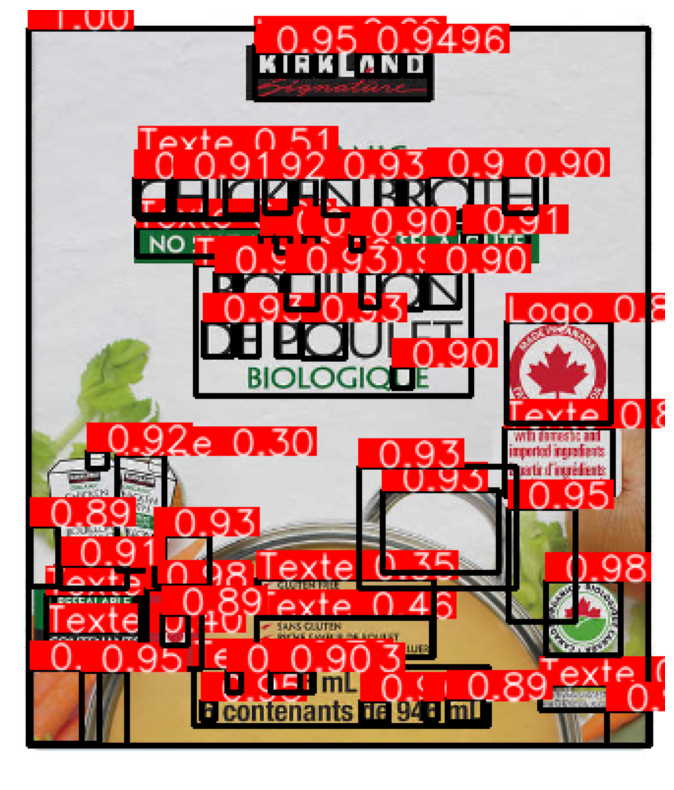


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40, 1 41, 1 42, 1 43, 1 44, 1 45, 1 46, 1 47, 1 48, 1 49, 1 50, 1 51, 1 52, 1 53, 1 54, 1 55, 1 56, 1 57, 1 58, 1 59, 1 60, 1 61, 1 62, 1 63, 1 64, 1 65, 17729.8ms
Speed: 7.0ms preprocess, 17729.8ms inference, 18.7ms postprocess per image at shape (1, 3, 1024, 1024)
/_____________________________/
Fichier 1: fde28d0e-Chickapea.PNG


Affichage de la detection des classes par YOLO




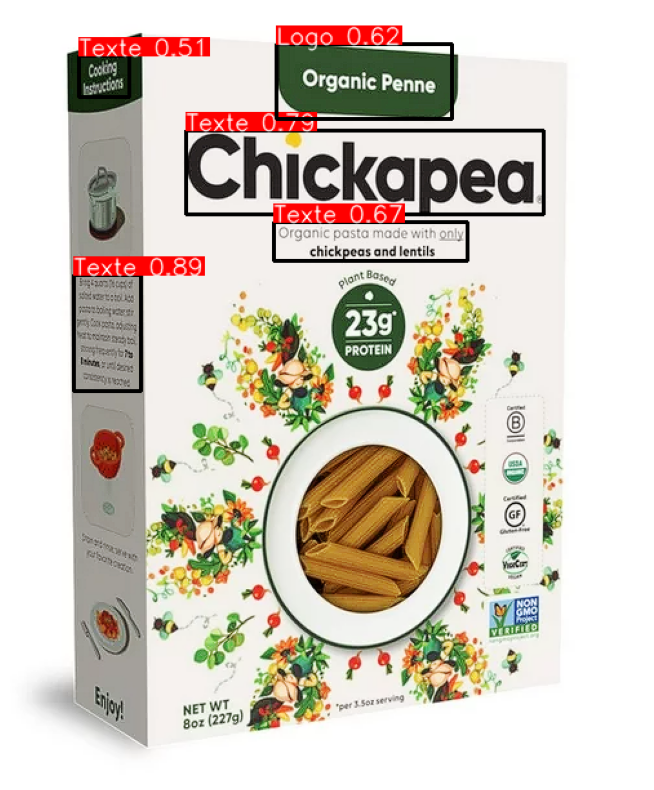





Affichage de la detection de forme par SAM




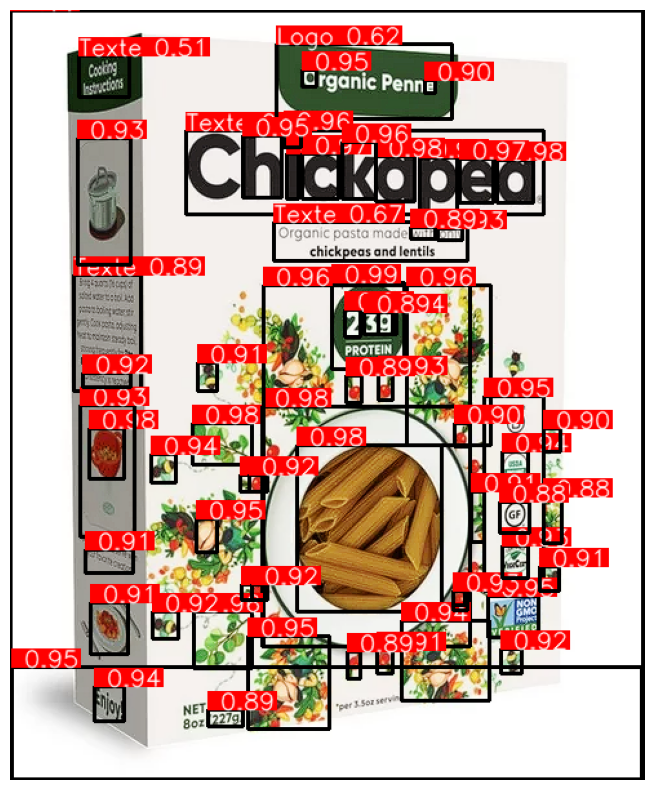

In [30]:
run_yolo_inference(image_files, custom_image_dir, yl)

## Training with Detr

In [10]:
sets = ['train', 'val']
root_dir = ""
for s in sets:
  label_path = Path(f"products_packaging/{s}/labels")
  image_path = Path(f"products_packaging/{s}/images")

  save_file = Path(f"products_packaging/coco/{s}.json")

  annotations = AnnotationSet.from_yolo(label_path, image_folder=image_path, image_extension=".png")

  annotations.save_coco(save_file, auto_ids=True)

  print(f"Stats of {s}")
  annotations.show_stats()
  print("\n")

/tmp/ipykernel_636/617974973.py:9: DeprecationWarning: 'from_yolo' is deprecated. Please use `from_yolo_darknet` or `from_yolo_v5`
  annotations = AnnotationSet.from_yolo(label_path, image_folder=image_path, image_extension=".png")


Stats of train


      Database Stats      
┏━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Label ┃ Images ┃ Boxes ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0     │     43 │    83 │
│ 1     │    166 │   212 │
│ 2     │     22 │    35 │
│ 3     │    179 │   959 │
├───────┼────────┼───────┤
│ Total │    191 │  1289 │
└───────┴────────┴───────┘



Stats of val


      Database Stats      
┏━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃ Label ┃ Images ┃ Boxes ┃
┡━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0     │     16 │    17 │
│ 1     │     69 │    90 │
│ 2     │      5 │     5 │
│ 3     │     74 │   379 │
├───────┼────────┼───────┤
│ Total │     77 │   491 │
└───────┴────────┴───────┘

In [9]:
# 3. Load the pretrained DETR model
feature_extractor = DetrFeatureExtractor.from_pretrained('facebook/detr-resnet-50')
detr_model = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50', num_labels=num_classes + 1, ignore_mismatched_sizes=True)

# 5. Prepare the data for training
train_dataset = CustomCocoDataset(
    annotations_file='products_packaging/coco/train.json',
    img_dir='products_packaging/train/images',
    feature_extractor=feature_extractor
)

val_dataset = CustomCocoDataset(
    annotations_file='products_packaging/coco/val.json',
    img_dir='products_packaging/val/images',
    feature_extractor=feature_extractor
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
ds = train_dataset

image_dir = ds.img_dir
image_id = 19  # Replace with your image ID

# Get image metadata
image_info = ds.coco.loadImgs(image_id)[0]

# Load the image using OpenCV
image_path = f"{image_dir}/{image_info['file_name']}"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Get all annotations for the image
ann_ids = ds.coco.getAnnIds(imgIds=image_id)
annotations = ds.coco.loadAnns(ann_ids)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")

# Overlay annotations
for ann in annotations:
    # If annotation has a bounding box, plot it
    if 'bbox' in ann:
        x, y, width, height = ann['bbox']
        plt.gca().add_patch(plt.Rectangle((x, y), width, height, edgecolor='red', facecolor='none', linewidth=2))

# Show the final plot
plt.title(f"Image ID: {image_id} with Annotations")
plt.show()

In [13]:
eval_compute_metrics_fn = partial(compute_metrics, image_processor=feature_extractor, id2label=id2label, threshold=0.0)

training_args = TrainingArguments(
    report_to=None,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    evaluation_strategy="epoch",
    # num_train_epochs=10,
    save_strategy="epoch",
    output_dir="./detr-finetuned",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="map_75",
    greater_is_better=True,
    eval_do_concat_batches=False,
    dataloader_drop_last=True,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    weight_decay=1e-4,
    max_grad_norm=0.01,
    num_train_epochs=100,
)


trainer = Trainer(
    model=detr_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=20)]
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Barcode,Mar 100 Barcode,Map Logo,Mar 100 Logo,Map Qrcode,Mar 100 Qrcode,Map Texte,Mar 100 Texte
1,No log,6.374765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000100,0.000300,0.001000,0.000000,0.000100,0.004300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003800
2,No log,6.337064,0.000000,0.000100,0.000000,0.000000,0.000000,0.000000,0.000400,0.000800,0.001800,0.000000,0.000300,0.007600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007100
3,No log,4.480013,0.000100,0.000600,0.000000,0.000000,0.000100,0.000700,0.000000,0.001100,0.009500,0.000000,0.006100,0.025300,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000400,0.038000
4,No log,4.216500,0.000200,0.000700,0.000000,0.000000,0.000100,0.000500,0.000300,0.002100,0.015300,0.000000,0.008000,0.046700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000600,0.061100
5,No log,4.281667,0.000100,0.000500,0.000000,0.000000,0.000100,0.000200,0.000200,0.001600,0.010300,0.000000,0.006000,0.029600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000400,0.041300
6,3.571600,3.914462,0.000200,0.000900,0.000000,0.000000,0.000100,0.000600,0.000500,0.002400,0.013200,0.000000,0.008700,0.034200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000600,0.052700
7,3.571600,3.626566,0.000100,0.000400,0.000000,0.000100,0.000000,0.000500,0.000000,0.001000,0.012600,0.002900,0.008100,0.032200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000400,0.050300
8,3.571600,3.488222,0.000100,0.000700,0.000000,0.000000,0.000100,0.000500,0.000000,0.000900,0.013900,0.000000,0.007600,0.041400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.055400
9,3.571600,3.328356,0.000200,0.001000,0.000000,0.000000,0.000100,0.000700,0.000300,0.002000,0.015600,0.000000,0.009400,0.043700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000700,0.062500
10,3.571600,3.476633,0.000200,0.001500,0.000000,0.000100,0.000200,0.000800,0.000100,0.003200,0.015400,0.003900,0.012500,0.030900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000900,0.061700


TrainOutput(global_step=7125, training_loss=3.290571498937774, metrics={'train_runtime': 5095.34, 'train_samples_per_second': 3.749, 'train_steps_per_second': 1.864, 'total_flos': 1.169994825983277e+19, 'train_loss': 3.290571498937774, 'epoch': 75.0})

In [ ]:
# Evaluate the model
metrics = trainer.evaluate()

# Save the best model
trainer.save_model("./best_detr_model")
print(metrics)

## Inference with DETR